$\text{Rishabh\ Pomaje}$<br>
210020036@iitdh.ac.in

> Simulating a traditional wireless communication system.
The following is the model description :
1. Channel Coding - `(7, 4)/(15,11) Hamming Code` (*if applicable*)
2. AWGN Channel (Real channel only for simplicity)                       
4. **SISO** - **S**ingle **I**nput **S**ingle **O**utput

In [14]:
import numpy as np 
import scipy as sp 
import matplotlib.pyplot as plt 
%config InlineBackend.figure_format='svg'
import itertools 

> Function Definitions 

In [15]:
def hamming_encoder(input_stream, gnrtr_matrix) :
    """
    Function that first generates a codebook depending on the generator matrix 
    (provide as a numpy multi-dimensional ndarray). 
    Using that codebook, it performs the channel coding using Hamming codes.
    Returns a channel coded bit stream generated as per the Generator Matrix specified.
    """  
    input_size = len(input_stream)
    # k = length of the input packet ; n = length of the output packet
    k, n = np.shape(gnrtr_matrix)
    # Generating the codebook :
    code_book = np.array([], dtype=int)
    possible_inputs = [list(i) for i in itertools.product([0, 1], repeat=k)]
    for i in range(2 ** k) :
        code_word = np.array(np.matmul(possible_inputs[i], gnrtr_matrix) % 2)
        code_book = np.append(code_book, code_word) 
    code_book = code_book.reshape(2 ** k, n)
    # Encoding the stream using the codebook :
    index = 0
    channel_coded_stream = []
    for i in range(input_size // k) :
        temp = input_stream[index:index+k]
        asgn_id = np.sum(temp * 2 ** np.arange(k - 1, -1, -1))
        channel_coded_stream.append(code_book[asgn_id])
        index = index + k
        
    channel_coded_stream = np.array(channel_coded_stream)

    return channel_coded_stream.flatten()

def BPSK_mapper(input_stream, energy_per_symbol) :
    """
    Function to perform constellation mapping on the input stream as per BPSK with given energy per symbol.
    Returns a ndarray consisting of complex symbols, each with magnitude energy per symbol.
    """
    output_stream = np.where(input_stream == 0, np.sqrt(energy_per_symbol), -1 * np.sqrt(energy_per_symbol))
    return output_stream

def BPSK_demapper(rx_stream) :
    """
    Function to perform BPSK constellation demapping
    Uses the MAP -> MLE -> Minimum distance method. The sufficient statistic used is the real part of the input 
    (possibly complex) signal.
    Returns the bit stream as per the minimum distance rule for demodulation.
    """
    rx_bits = np.where(np.real(rx_stream) > 0 , 0, 1)
    return rx_bits

def hamming_decoder(rx_stream, parity_chk_matrix):
    """
    Function to perform hard decision syndrome decoding for Hamming codes, given a bit stream and parity check matrix 
    as input.
    Returns 't-error' corrected stream. The current implementation is matrix based and hence inefficient.
    NOTE: The matrices provided as inputs to this function must be ndarray with dtype = int.
    """
    # Get the size of the input stream and dimensions of the parity check matrix
    input_size = len(rx_stream)
    k_1, n = parity_chk_matrix.shape
    k = n - k_1
    decoded_stream = np.zeros((input_size // n, k), dtype=int)
    # Generating the syndrome book :
    possible_single_errors = np.eye(n, dtype=int) 
    syndrome_book = parity_chk_matrix.T
    # Performing the syndrome decoding :
    num_blocks = input_size // n 
    for idx in range(num_blocks):
        rx_packet = rx_stream[idx * n: (idx + 1) * n]  # Extract packet for processing
        syndrome = np.matmul(rx_packet, parity_chk_matrix.T) % 2
        if np.sum(syndrome) != 0 :
        # Correcting 1-bit errors :
            for j in range(n):
                if np.array_equal(syndrome, syndrome_book[j]):
                    rx_packet = np.bitwise_xor(rx_packet, possible_single_errors[j])
        decoded_stream[idx] = rx_packet[:k]  # Append the corrected packet
        
    return decoded_stream.flatten()

def ML_Detection(rx_signal, G, E_sym, n, k) :
    """ 
    Function to perform Maximum Likelihood Decoding for Hamming Code.
    """
    # Matrix of all possible codewords :
    code_book = np.array([], dtype=int)
    possible_inputs = [list(i) for i in itertools.product([0, 1], repeat=k)]
    for i in range(2 ** k) :
        code_word = np.array(np.matmul(possible_inputs[i], G) % 2)
        code_book = np.append(code_book, code_word)
    C = BPSK_mapper(code_book, E_sym)  
    code_book = code_book.reshape(2 ** k, n)
    C = C.reshape(2 ** k, n)
    
    # Finding the MLD Estimates :
    n_blocks = len(rx_signal) // n
    estimates = []
    for i in range(n_blocks):
        start_idx = i * n
        end_idx = (i + 1) * n
        received_segment = rx_signal[start_idx:end_idx]
        distances = [np.linalg.norm(C[j] - received_segment) for j in range(2**k)]
        nearest_codeword_idx = np.argmin(distances)
        nearest_codeword = code_book[nearest_codeword_idx]  
        estimates.append(np.array(nearest_codeword[0:k])) # Extracting the first k bits
    
    return np.array(estimates).flatten()

def calcBLER(original_message, estimated_message, block_length) :
    """ 
    Function to calculate the block error rate 
    """
    n_errors = 0
    n_blocks = len(original_message) // block_length
    idx = 0
    for _ in range(n_blocks) :
        if not np.all(original_message[idx:idx+block_length] == estimated_message[idx:idx+block_length]) :
            n_errors += 1 
        idx += block_length  
    return [n_errors, n_errors / n_blocks]      

In [16]:
# Uncoded and Coded block lengths 
# k = 4
# n = 7
k = 11
n = 15
# Information Rate 
R = k / n
# Energy per bit 
E_b = 1
# Signal-Noise-Ratio (SNR) range in dB and linear scale :
SNR_dB = np.linspace(-4, 8, 25)
n_values = len(SNR_dB)
SNR_lin = 10 ** (SNR_dB / 10)
# Fixed Variance of real noise for a particular SNR
noise_var_coded = 1 / (2 * R * SNR_lin)
noise_var_uncoded = 1 / (2 * SNR_lin)

> Data generation 

In [17]:
# Generating random binary data :
n_bits = 5 * (10 ** 6)
binary_stream_tx = np.random.randint(0, 2, n_bits)
print(f'Sample : {binary_stream_tx[:10]}')

Sample : [1 1 1 0 1 1 0 0 1 1]


> Channel Coding 
- (7, 4) Hamming Code 

In [18]:
# Generator matrix for (7, 4) Hamming Code :
G = np.array(
    [
        [1, 0, 0, 0, 1, 1, 0],
        [0, 1, 0, 0, 1, 0, 1],
        [0, 0, 1, 0, 0, 1, 1],
        [0, 0, 0, 1, 1, 1, 1]
    ], dtype=int)
# Parity Check Matrix for (7, 4) Hamming Code :
H = np.array([
    [1, 1, 0, 1, 1, 0, 0],
    [1, 0, 1, 1, 0, 1, 0],
    [0, 1, 1, 1, 0, 0, 1]
    ], dtype=int)
channel_coded_stream_tx = hamming_encoder(binary_stream_tx, G)
print(channel_coded_stream_tx)

[1 1 1 ... 1 0 1]


- Alternative : (15, 11) Hamming Code

In [19]:
G_15 = np.array([
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1],
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1],
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1],
], dtype=int)

H_15 = np.array([
    [1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0],
    [1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0],
    [0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0],
    [0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1]
], dtype=int)
channel_coded_stream_tx = hamming_encoder(binary_stream_tx, G_15)
print(channel_coded_stream_tx)

[1 1 1 ... 0 1 1]


> Constellation Mapping 
- Per bit energies :
- BPSK : {$\pm \sqrt{E_{b}}$}
- $E_{uncoded} = 1 = \text{Budgeted from the hardware at the final output}$
\begin{equation}
E_{coded} = E_{uncoded} \times k / n = E_{uncoded} \times R
\end{equation}
- $R$ = Information Rate 
- $\color{red}{Note}$ : This difference in energy per bit needs to be compensated in either symbol energy or the noise variance. I have arbitrarily chosen it to be the noise variance.

In [20]:
# For coded stream :
signal_stream_tx_c = BPSK_mapper(channel_coded_stream_tx, E_b)
# For uncoded stream :
signal_stream_tx_uc = BPSK_mapper(binary_stream_tx, E_b)
# Sample :
print(signal_stream_tx_c[:10])
curr_size = len(signal_stream_tx_c)

[-1. -1. -1.  1. -1. -1.  1.  1. -1. -1.]


> Modeling the Channel followed by Receiver :
- AWGN channel with $w \sim \mathcal{CN}(0, N_0)$
- But we will be using only real $w_R\sim \mathcal{N}(0, N_0 / 2)$

> Hamming Code with Hard decision + Syndrome decoding

In [21]:
# Performing Hamming + BPSK + Hard decision + Syndrome Decoding :
count = 0
BLER_coded_hard = []

for noise in noise_var_coded :
    # All White Gaussian Noise :
    # Using the y[i] = x[i] + w[i] model :
    signal_stream_rx = signal_stream_tx_c + np.sqrt(noise) * np.random.normal(0, 1, curr_size)
    # BPSK Demapping (Hard Decision) :
    channel_coded_stream_rx = BPSK_demapper(signal_stream_rx)
    # (7, 4) Hamming Decoder : Syndrome Decoding
    binary_stream_rx = hamming_decoder(channel_coded_stream_rx, H_15)
    # Analysing the BLER :
    _, BLER = calcBLER(binary_stream_tx, binary_stream_rx, k)
    BLER_coded_hard.append(BLER)
    count += 1
    print(f'Progress : {100 * count // n_values} %', end='\r')

> Comparing with Hamming (MLD) Soft decision 

In [22]:
# Performing Hamming + BPSK + MLD(Soft decision) :
BLER_coded_MLD = []
count = 0
for noise in noise_var_coded :
    # BPSK Mapping :
    # AWGN Channel :
    signal_stream_rx = signal_stream_tx_c + np.sqrt(noise) * np.random.normal(0, 1, curr_size)
    # BPSK Demapping (Maximum-Likelihood Soft Decision) :
    binary_stream_rx = ML_Detection(signal_stream_rx, G_15, E_b, n, k) 
    # Counting the Errors and storing the BER :
    _, BLER = calcBLER(binary_stream_tx, binary_stream_rx, k)
    BLER_coded_MLD.append(BLER)
    count = count + 1
    print(f'Progress : {100 * count // n_values} %', end='\r')

> Comparing with uncoded BPSK 

In [23]:
# Peforming BPSK Signalling :
BLER_uncoded = []
count = 0

for noise in noise_var_uncoded :
    # AWGN Channel : y[i] = x[i] + w[i] : Only real channel
    signal_stream_rx = signal_stream_tx_uc + np.sqrt(noise) * np.random.normal(0, 1, n_bits)
    # BPSK Demapping (Minimum-Distance) :
    binary_stream_rx = BPSK_demapper(signal_stream_rx)
    # Counting the Errors and storing the BER :
    _, BLER = calcBLER(binary_stream_tx, binary_stream_rx, k)
    BLER_uncoded.append(BLER)
    count = count + 1
    print(f'Progress : {100 * count // n_values} %', end='\r')

> Results 
- Performance metric being used is Block Error Rate

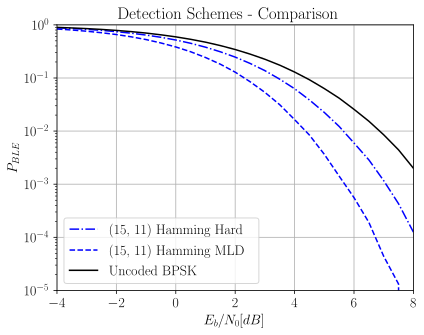

In [24]:
plt.rcParams.update({
    "text.usetex": True,
    "font.size": 14,
    "font.family" : 'Serif'
})
fig, axes = plt.subplots()
adj_fac = 10*np.log10(2)
axes.semilogy(SNR_dB, BLER_coded_hard, label='(15, 11) Hamming Hard', color='blue', ls='-.')
axes.semilogy(SNR_dB, BLER_coded_MLD, label='(15, 11) Hamming MLD', color='blue', ls='--')
axes.semilogy(SNR_dB, BLER_uncoded, label='Uncoded BPSK', color='black')
axes.set_xlabel(r'$E_b / N_0 [dB]$')
axes.set_ylabel(r'$P_{BLE}$')
axes.set_xlim(-4, 8)
axes.set_ylim(10**-5,10**0)
axes.legend()
axes.set_title(f'Detection Schemes - Comparison')
axes.grid(True, which="major")
fig.savefig('plots/tradComm_15_11.svg', transparent=True)

<img src='plots/expected_trad.png' width=575px>

In [25]:
print(f'BLER_coded_hard = {BLER_coded_hard}')
print(f'BLER_coded_MLD = {BLER_coded_MLD}')
print(f'BLER_uncoded = {BLER_uncoded}')

BLER_coded_hard = [0.8788502788502789, 0.8528990528990529, 0.8223102223102223, 0.7868505868505868, 0.743932943932944, 0.696980496980497, 0.641967241967242, 0.5832205832205832, 0.5182325182325183, 0.4499246499246499, 0.3801075801075801, 0.31112651112651113, 0.2472912472912473, 0.18811338811338812, 0.13742093742093742, 0.0948068948068948, 0.06273746273746274, 0.038533038533038536, 0.02244002244002244, 0.012238612238612239, 0.005966405966405967, 0.0028732028732028733, 0.001166001166001166, 0.000429000429000429, 0.0001254001254001254]
BLER_coded_MLD = [0.835094435094435, 0.8003080003080003, 0.7588445588445588, 0.7105149105149106, 0.6573540573540574, 0.5954195954195954, 0.5285307285307286, 0.455946055946056, 0.38364298364298366, 0.3118371118371118, 0.24306284306284306, 0.18166298166298167, 0.1287023287023287, 0.08510268510268511, 0.05355685355685356, 0.03136103136103136, 0.016436216436216435, 0.00841060841060841, 0.0036586036586036584, 0.0014212014212014212, 0.0005588005588005588, 0.0001914

In [27]:
with open("results/results_tradComm_15_11.txt", mode='w') as file_id :
    file_id.write("BLER_uncoded = ")
    file_id.write(f'{str(BLER_uncoded)}\n')
    file_id.write("BLER_coded_hard = ")
    file_id.write(f'{str(BLER_coded_hard)}\n')
    file_id.write("BLER_coded_MLD = ")
    file_id.write(f'{str(BLER_coded_MLD)}\n')